**The Final Analysis Notebook For The Convoy Data Ensemble Model**

In [47]:
#Imports
#Imports
import numpy as np
import pandas as pd
import sys, os, random
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (roc_auc_score, recall_score, precision_score, f1_score, matthews_corrcoef, \
                             balanced_accuracy_score, confusion_matrix,classification_report )
from pathlib import Path
from datetime import datetime
import json
import joblib

#Warning Supression
import warnings
warnings.filterwarnings("ignore", module="skopt") #Ignore scikit-optimize warning print lines
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning) #For QDA
warnings.filterwarnings("ignore", category=UserWarning) #For LightBoost

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import ML_Class_2
importlib.reload(ML_Class_2) #Ensures file is uptodate!
from src.models.ML_Class_2 import Model_Tester_V2

#Utils Import
from src.models.model_artifacts import (get_artifact_dir, load_model, load_models, save_model, save_models,)
ARTIFACT_DIR = get_artifact_dir("algorithm_test_3")
from src.models import model_specs
importlib.reload(model_specs) #Ensures file is uptodate!
from src.models.model_specs import MODEL_SPECS
from src.models.perf_utils import track_performance

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)

In [48]:
#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
# df.shape #Test
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [49]:
#Feature Names for later feature analysis:
feature_names = list(df)
# feature_names[:-1]

In [50]:
#Model Tester Utility Function

#Shared split for all models/ensembles
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=1945,
    stratify=y,)

def prepare_tester(model_key, *, scaler=None, cv_folds=None):
    spec = MODEL_SPECS[model_key]
    tester = Model_Tester_V2(
        model=spec["estimator"],
        scaler=scaler,
        parameter_grid=spec["grid_large"],
        cv_folds=cv_folds or spec.get("cv_folds", 5),
        feature_names=feature_names,
        model_config=spec["config"],)
    tester.X_train, tester.X_test = X_train, X_test
    tester.y_train, tester.y_test = y_train, y_test
    if callable(tester.parameter_grid):
        tester.parameter_grid = tester.parameter_grid(tester.y_train)
    return tester

In [51]:
# --- Voting Ensemble Evaluator ---

def evaluate_voting_ensemble(
    estimators_dict,
    X_train,
    X_test,
    y_train,
    y_test,
    threshold=0.5,
    voting="soft",
    ensemble_name=None,
    pos_label=1,
    verbose=True,
    weights=None,
):
    estimators_list = [(name, est) for name, est in estimators_dict.items()]
    if ensemble_name is None:
        ensemble_name = "VotingEnsemble_" + "_".join(sorted(estimators_dict.keys()))

    voter = VotingClassifier(
        estimators=estimators_list,
        voting=voting,
        weights=weights,
        n_jobs=-1,
    )
    voter.fit(X_train, y_train)

    if voting == "soft":
        proba_pos = voter.predict_proba(X_test)[:, 1]
        y_pred = (proba_pos >= threshold).astype(int)
    else:
        y_pred = voter.predict(X_test)
        proba_pos = None

    roc_auc = roc_auc_score(y_test, proba_pos) if proba_pos is not None else np.nan
    acc = np.mean(y_pred == y_test)
    recall_1 = recall_score(y_test, y_pred, pos_label=pos_label)
    precision_1 = precision_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, pos_label=pos_label, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=["True 0", "True 1"], columns=["Pred 0", "Pred 1"])
    cls_report = classification_report(y_test, y_pred, digits=3, zero_division=0)

    if verbose:
        print(f"Ensemble: {ensemble_name}")
        print(f"Voting: {voting}")
        if voting == "soft":
            print(f"Threshold: {threshold:.2f}")
        if weights is not None:
            print(f"Weights: {weights}")
        print(f"ROC AUC: {roc_auc:.3f}")
        print(f"Accuracy: {acc:.3f}")
        print(f"Recall (class {pos_label}): {recall_1:.3f}")
        print(f"Precision (class {pos_label}): {precision_1:.3f}")
        print(f"F1 (class {pos_label}): {f1_1:.3f}")
        print(f"MCC: {mcc:.3f}")
        print(f"Balanced Accuracy: {bal_acc:.3f}")
        print("Confusion Matrix:")
        print(cm_df)
        print("Classification Report (digits=3):")
        print(cls_report)

    results_df = pd.DataFrame([
        {
            "Model": ensemble_name,
            "Threshold": threshold if voting == "soft" else np.nan,
            "Acc": acc,
            "ROC_AUC": roc_auc,
            "MCC": mcc,
            "Bal_Acc": bal_acc,
            "Recall_1": recall_1,
            "Precision_1": precision_1,
            "F1_1": f1_1,
        }
    ])

    return results_df, voter, cm_df, cls_report


# --- Load ALL MODELS USED IN FINAL ENSEMBLE MODEL --- 


# --- DecisionTreeClassifier ---
dt = prepare_tester("dt")
load_model("dt", directory=ARTIFACT_DIR, assign_to=dt)
# dt_results = dt.evaluate(show_plots=False)

# --- RandomForestClassifier ---
rf = prepare_tester("rf")
load_model("rf", directory=ARTIFACT_DIR, assign_to=rf)
# fr_results = rf.evaluate(show_plots=False)

# --- ExtraTreesClassifier ---
et = prepare_tester("et")
load_model("et", directory=ARTIFACT_DIR, assign_to=et)
# et_results = et.evaluate(show_plots=False)


# --- AdaBoostClassifier ---
ada = prepare_tester("ada")
load_model("ada", directory=ARTIFACT_DIR, assign_to=ada)
# ada_results = ada.evaluate(show_plots=False)

# --- QuadraticDiscriminantAnalysis ---
qda = prepare_tester("qda")
load_model("qda", directory=ARTIFACT_DIR, assign_to=qda)
# qda_results = qda.evaluate(show_plots=False)



,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,priors,None
,reg_param,0.0
,store_covariance,False
,tol,0.001


In [52]:
# --- Five Model Ensemble ---

#Models
dt_ensemble = dt.best_model
rf_ensemble = rf.best_model
et_ensemble = et.best_model
ada_ensemble = ada.best_model
qda_ensemble = qda.best_model

def run_five_model_calsoft_t025(
    X_train, X_test, y_train, y_test,
    qda_ensemble, ada_ensemble, dt_ensemble, rf_ensemble, et_ensemble,
):
    five_model_ensemble = {
        "qda": qda_ensemble,
        "ada": ada_ensemble,
        "dt": dt_ensemble,
        "rf": rf_ensemble,
        "et": et_ensemble,
    }

    calibrated_five = {}
    for name, est in five_model_ensemble.items():
        cal = CalibratedClassifierCV(est, method="sigmoid", cv=3)
        cal.fit(X_train, y_train)
        calibrated_five[name] = cal

    return evaluate_voting_ensemble(
        calibrated_five,
        X_train,
        X_test,
        y_train,
        y_test,
        threshold=0.25,
        voting="soft",
        ensemble_name="FiveModel_CalSoft_t0.25",)


res_calsoft_025, voter_calsoft_025, cm_calsoft_025, rep_calsoft_025 = run_five_model_calsoft_t025(
    X_train,
    X_test,
    y_train,
    y_test,
    qda_ensemble,
    ada_ensemble,
    dt_ensemble,
    rf_ensemble,
    et_ensemble,)

res_calsoft_025

Ensemble: FiveModel_CalSoft_t0.25
Voting: soft
Threshold: 0.25
ROC AUC: 0.821
Accuracy: 0.830
Recall (class 1): 0.680
Precision (class 1): 0.586
F1 (class 1): 0.630
MCC: 0.522
Balanced Accuracy: 0.775
Confusion Matrix:
        Pred 0  Pred 1
True 0     161      24
True 1      16      34
Classification Report (digits=3):
              precision    recall  f1-score   support

           0      0.910     0.870     0.890       185
           1      0.586     0.680     0.630        50

    accuracy                          0.830       235
   macro avg      0.748     0.775     0.760       235
weighted avg      0.841     0.830     0.834       235



,Model,Threshold,Acc,ROC_AUC,MCC,Bal_Acc,Recall_1,Precision_1,F1_1
0,FiveModel_CalSoft_t0.25,0.25,0.829787,0.820865,0.522332,0.775135,0.68,0.586207,0.62963


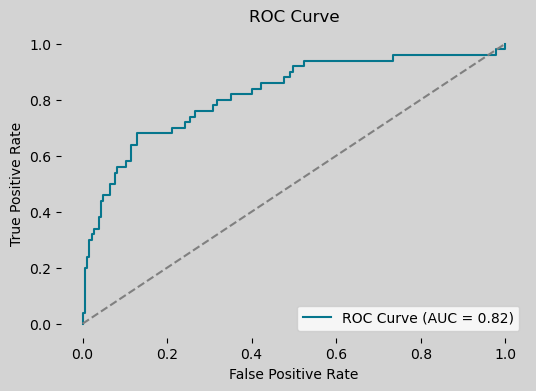

In [53]:
# ROC Curve Plot (FiveModel_CalSoft_t0.25)
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, ROC_AUC, model_name):
    """
    ROC Curve Plot
    """
    plt.figure(figsize=(6,4), facecolor='lightgrey')
    plt.plot(fpr, tpr, color='#06768d', label=f'ROC Curve (AUC = {ROC_AUC:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    ax = plt.gca()
    ax.set_facecolor('lightgrey')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/{model_name}_PR_Curve.png")
    plt.show()

model_name = "FiveModel_CalSoft_t0.25"
y_proba = voter_calsoft_025.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
ROC_AUC = roc_auc_score(y_test, y_proba)
plot_roc_curve(fpr, tpr, ROC_AUC, model_name=model_name)


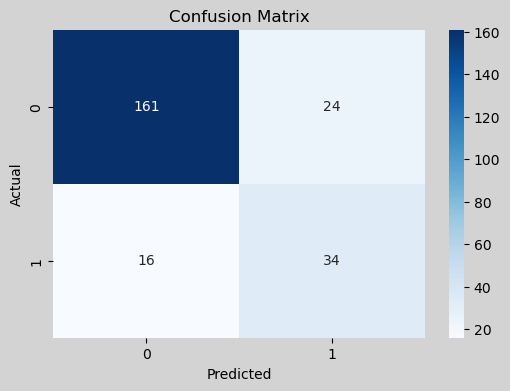

In [54]:
# Confusion Matrix Plot (FiveModel_CalSoft_t0.25)

def plot_confusion_matrix(cm, model_name, class_labels=None):
    """
    Plot Confusion Matrix
    """
    if class_labels is None:
        labels_to_use = [str(i) for i in range(cm.shape[0])]
    else:
        labels_to_use = [str(label) for label in class_labels]

    plt.figure(figsize=(6,4), facecolor='lightgrey')
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_to_use, \
                yticklabels=labels_to_use)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/{model_name}_CM.png")
    plt.show()

model_name = "FiveModel_CalSoft_t0.25"
y_proba = voter_calsoft_025.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.25).astype(int)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, model_name=model_name, class_labels=[0, 1])


In [ ]:
# Permutation Importance (FiveModel_CalSoft_t0.25)
from sklearn.inspection import permutation_importance

model_name = "FiveModel_CalSoft_t0.25"
perm = permutation_importance(
    voter_calsoft_025,
    X_test,
    y_test,
    n_repeats=30,
    random_state=1945,
    scoring="recall",
)

perm_df = pd.DataFrame({
    "Feature": feature_names[:len(perm.importances_mean)],
    "Importance": perm.importances_mean,
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,4), facecolor='lightgrey')
ax = sns.barplot(x="Importance", y="Feature", data=perm_df, palette='crest_r')
plt.title('Permutation Importance')
ax.set_facecolor('lightgrey')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/{model_name}_Permutation_Importance.png")
plt.show()
perm_df


In [ ]:
# Aggregated Base-Model Importance (FiveModel_CalSoft_t0.25)

def _extract_importance_from_estimator(est):
    if hasattr(est, "named_steps") and "model" in est.named_steps:
        est = est.named_steps["model"]
    if hasattr(est, "feature_importances_"):
        return np.asarray(est.feature_importances_)
    if hasattr(est, "coef_"):
        coef = np.asarray(est.coef_)
        if coef.ndim == 1:
            return np.abs(coef)
        return np.mean(np.abs(coef), axis=0)
    return None

def _unwrap_calibrated(est):
    if hasattr(est, "calibrated_classifiers_") and len(est.calibrated_classifiers_) > 0:
        imps = []
        for cc in est.calibrated_classifiers_:
            base = getattr(cc, "estimator", None)
            if base is None:
                continue
            imp = _extract_importance_from_estimator(base)
            if imp is not None:
                imps.append(np.asarray(imp))
        if imps:
            min_len = min(len(i) for i in imps)
            return np.mean([i[:min_len] for i in imps], axis=0)
    return _extract_importance_from_estimator(est)

model_name = "FiveModel_CalSoft_t0.25"
base_imps = []
for est in voter_calsoft_025.estimators_:
    imp = _unwrap_calibrated(est)
    if imp is not None:
        base_imps.append(np.asarray(imp))

if not base_imps:
    print('No base estimators exposed feature importances/coefficients.')
else:
    min_len = min(len(i) for i in base_imps)
    agg_imp = np.mean([i[:min_len] for i in base_imps], axis=0)
    agg_df = pd.DataFrame({
        "Feature": feature_names[:len(agg_imp)],
        "Importance": agg_imp,
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(8,4), facecolor='lightgrey')
    ax = sns.barplot(x="Importance", y="Feature", data=agg_df, palette='crest_r')
    plt.title('Aggregated Base-Model Importance')
    ax.set_facecolor('lightgrey')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/{model_name}_Aggregated_Importance.png")
    plt.show()
    agg_df


In [ ]:
# SHAP Importance (Tree Models in FiveModel_CalSoft_t0.25)

model_name = "FiveModel_CalSoft_t0.25"
try:
    import shap
except ImportError:
    print("SHAP is not installed. Install with: pip install shap")
else:
    shap_imps = []

    def _unwrap_for_shap(est):
        if hasattr(est, "calibrated_classifiers_") and len(est.calibrated_classifiers_) > 0:
            return getattr(est.calibrated_classifiers_[0], "estimator", est)
        return est

    for est in voter_calsoft_025.estimators_:
        base = _unwrap_for_shap(est)
        if hasattr(base, "named_steps") and "model" in base.named_steps:
            base = base.named_steps["model"]

        if not hasattr(base, "predict"):
            continue

        try:
            explainer = shap.TreeExplainer(base)
            shap_vals = explainer.shap_values(X_test)
            if isinstance(shap_vals, list):
                vals = np.asarray(shap_vals[-1])
            else:
                vals = np.asarray(shap_vals)
            mean_abs = np.mean(np.abs(vals), axis=0)
            shap_imps.append(mean_abs)
        except Exception:
            continue

    if not shap_imps:
        print('No compatible tree estimators available for SHAP in this ensemble.')
    else:
        min_len = min(len(i) for i in shap_imps)
        shap_mean = np.mean([i[:min_len] for i in shap_imps], axis=0)
        shap_df = pd.DataFrame({
            "Feature": feature_names[:len(shap_mean)],
            "Importance": shap_mean,
        }).sort_values(by="Importance", ascending=False)

        plt.figure(figsize=(8,4), facecolor='lightgrey')
        ax = sns.barplot(x="Importance", y="Feature", data=shap_df, palette='crest_r')
        plt.title('SHAP Feature Importance (Tree Base Models)')
        ax.set_facecolor('lightgrey')
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        plt.savefig(f"/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/{model_name}_SHAP_Importance.png")
        plt.show()
        shap_df
